# オートエンコーダ

# Time Series Anomaly Detection with LSTM Autoencoders using Keras in Python

https://www.youtube.com/watch?v=H4J74KstHTE&t=699s

https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/#lstm-autoencoders

オートエンコーダ解説
https://jp.mathworks.com/discovery/autoencoder.html

おーっとエンコーダ数式https://www.jeremyjordan.me/autoencoders/
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

複数のオートエンコーダアルゴリズム
https://machinelearningmastery.com/lstm-autoencoders/

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from keras.models import Model

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

traindata

In [9]:
import pandas as pd

train = pd.read_csv('data/sensor_train_60.csv')
train = train.rename(columns={'4095':'data'})
train.head()

,data
0,4095
1,4095
2,4095
3,4095
4,4095


In [10]:
train = train[1500: 2500].reset_index(drop=True)

In [11]:
train

,data
0,2934
1,3663
2,3402
3,3005
4,2607
...,...
995,4095
996,3491
997,2559
998,2321


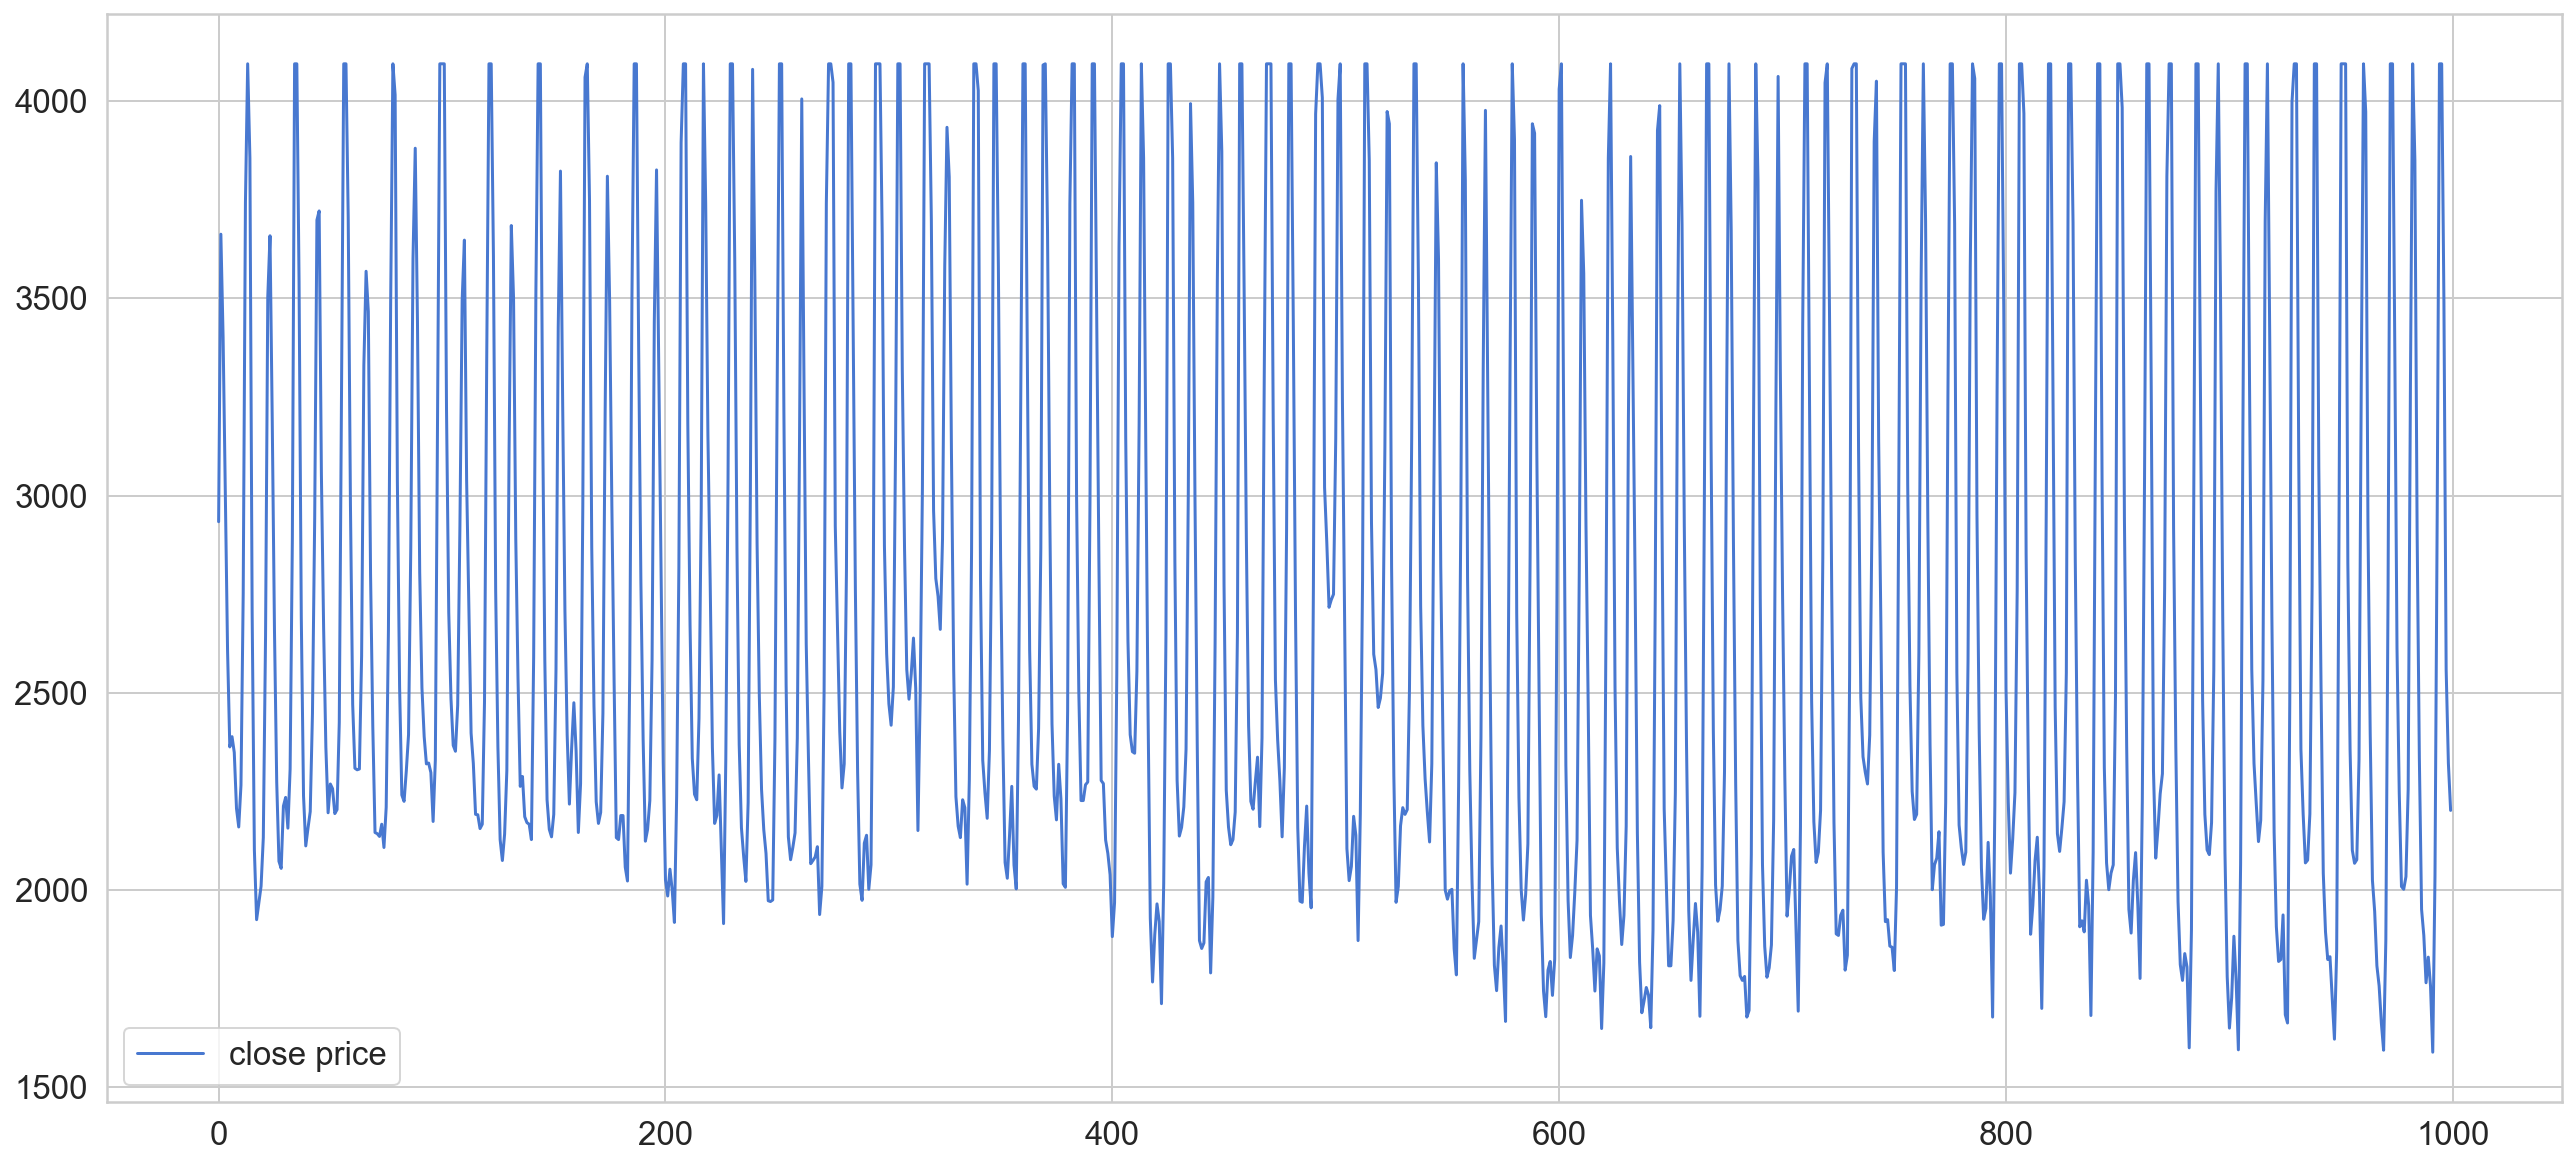

In [13]:
plt.plot(train, label='close price')
plt.legend();

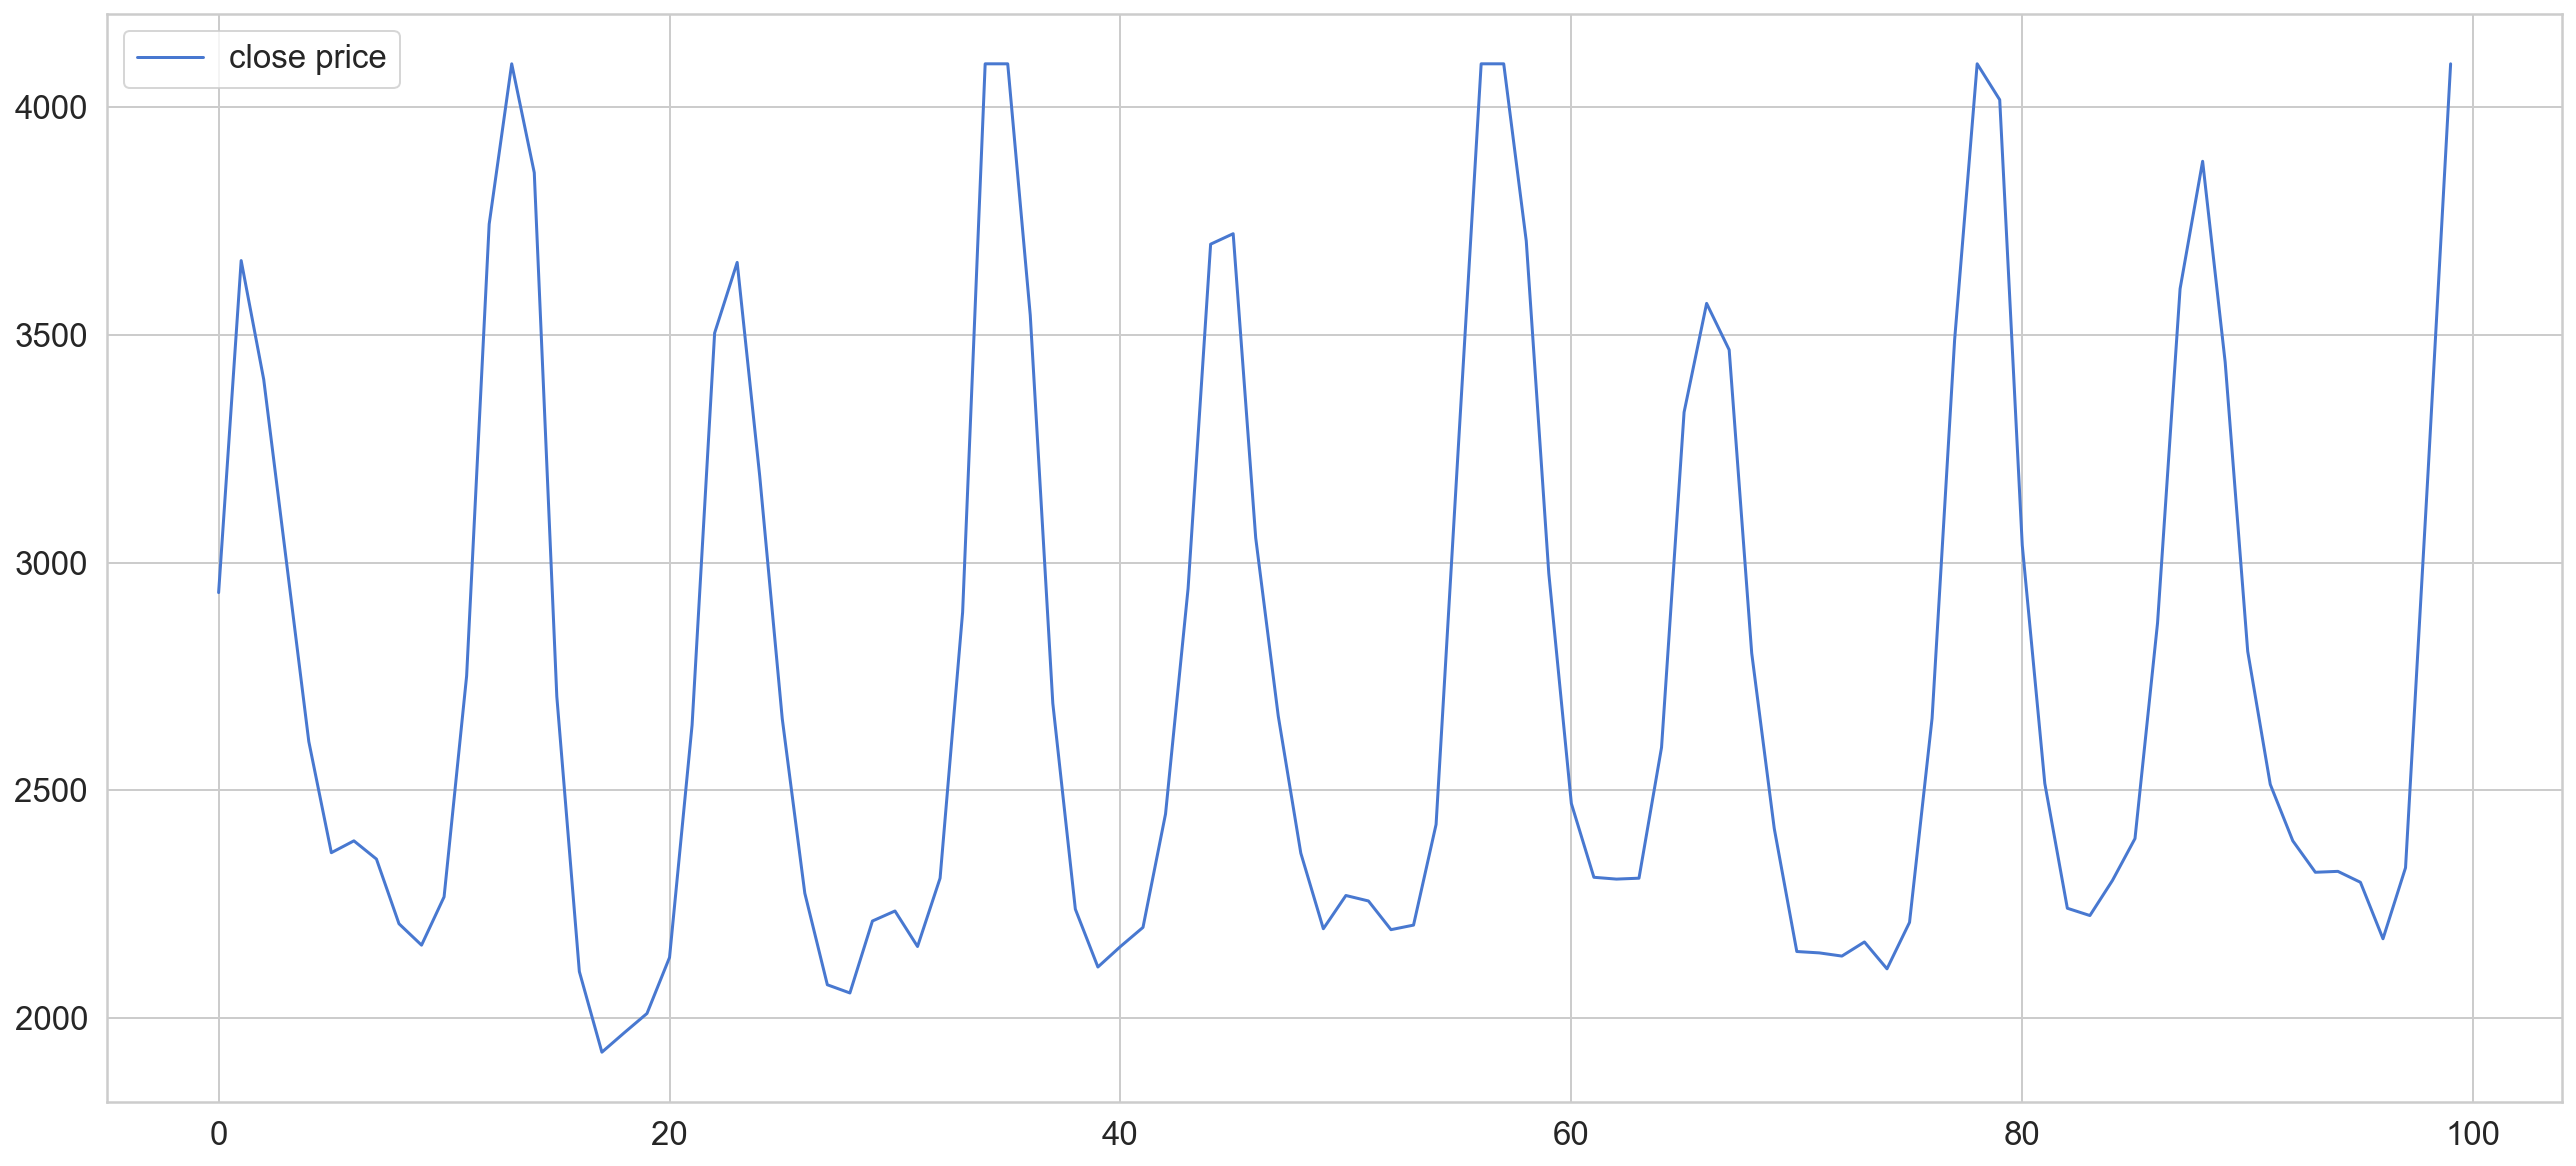

In [12]:
plt.plot(train[0: 100], label='close price')
plt.legend();

In [ ]:
plt.plot(train, label='close price')
plt.legend();

testdata

In [14]:
import pandas as pd

test = pd.read_csv('data/sensor_test1.csv')
test = test.rename(columns={'3636':'data'})
test.head()

,data
0,3649
1,3666
2,3671
3,3698
4,3726


In [15]:
test = test[200: 900].reset_index(drop=True)

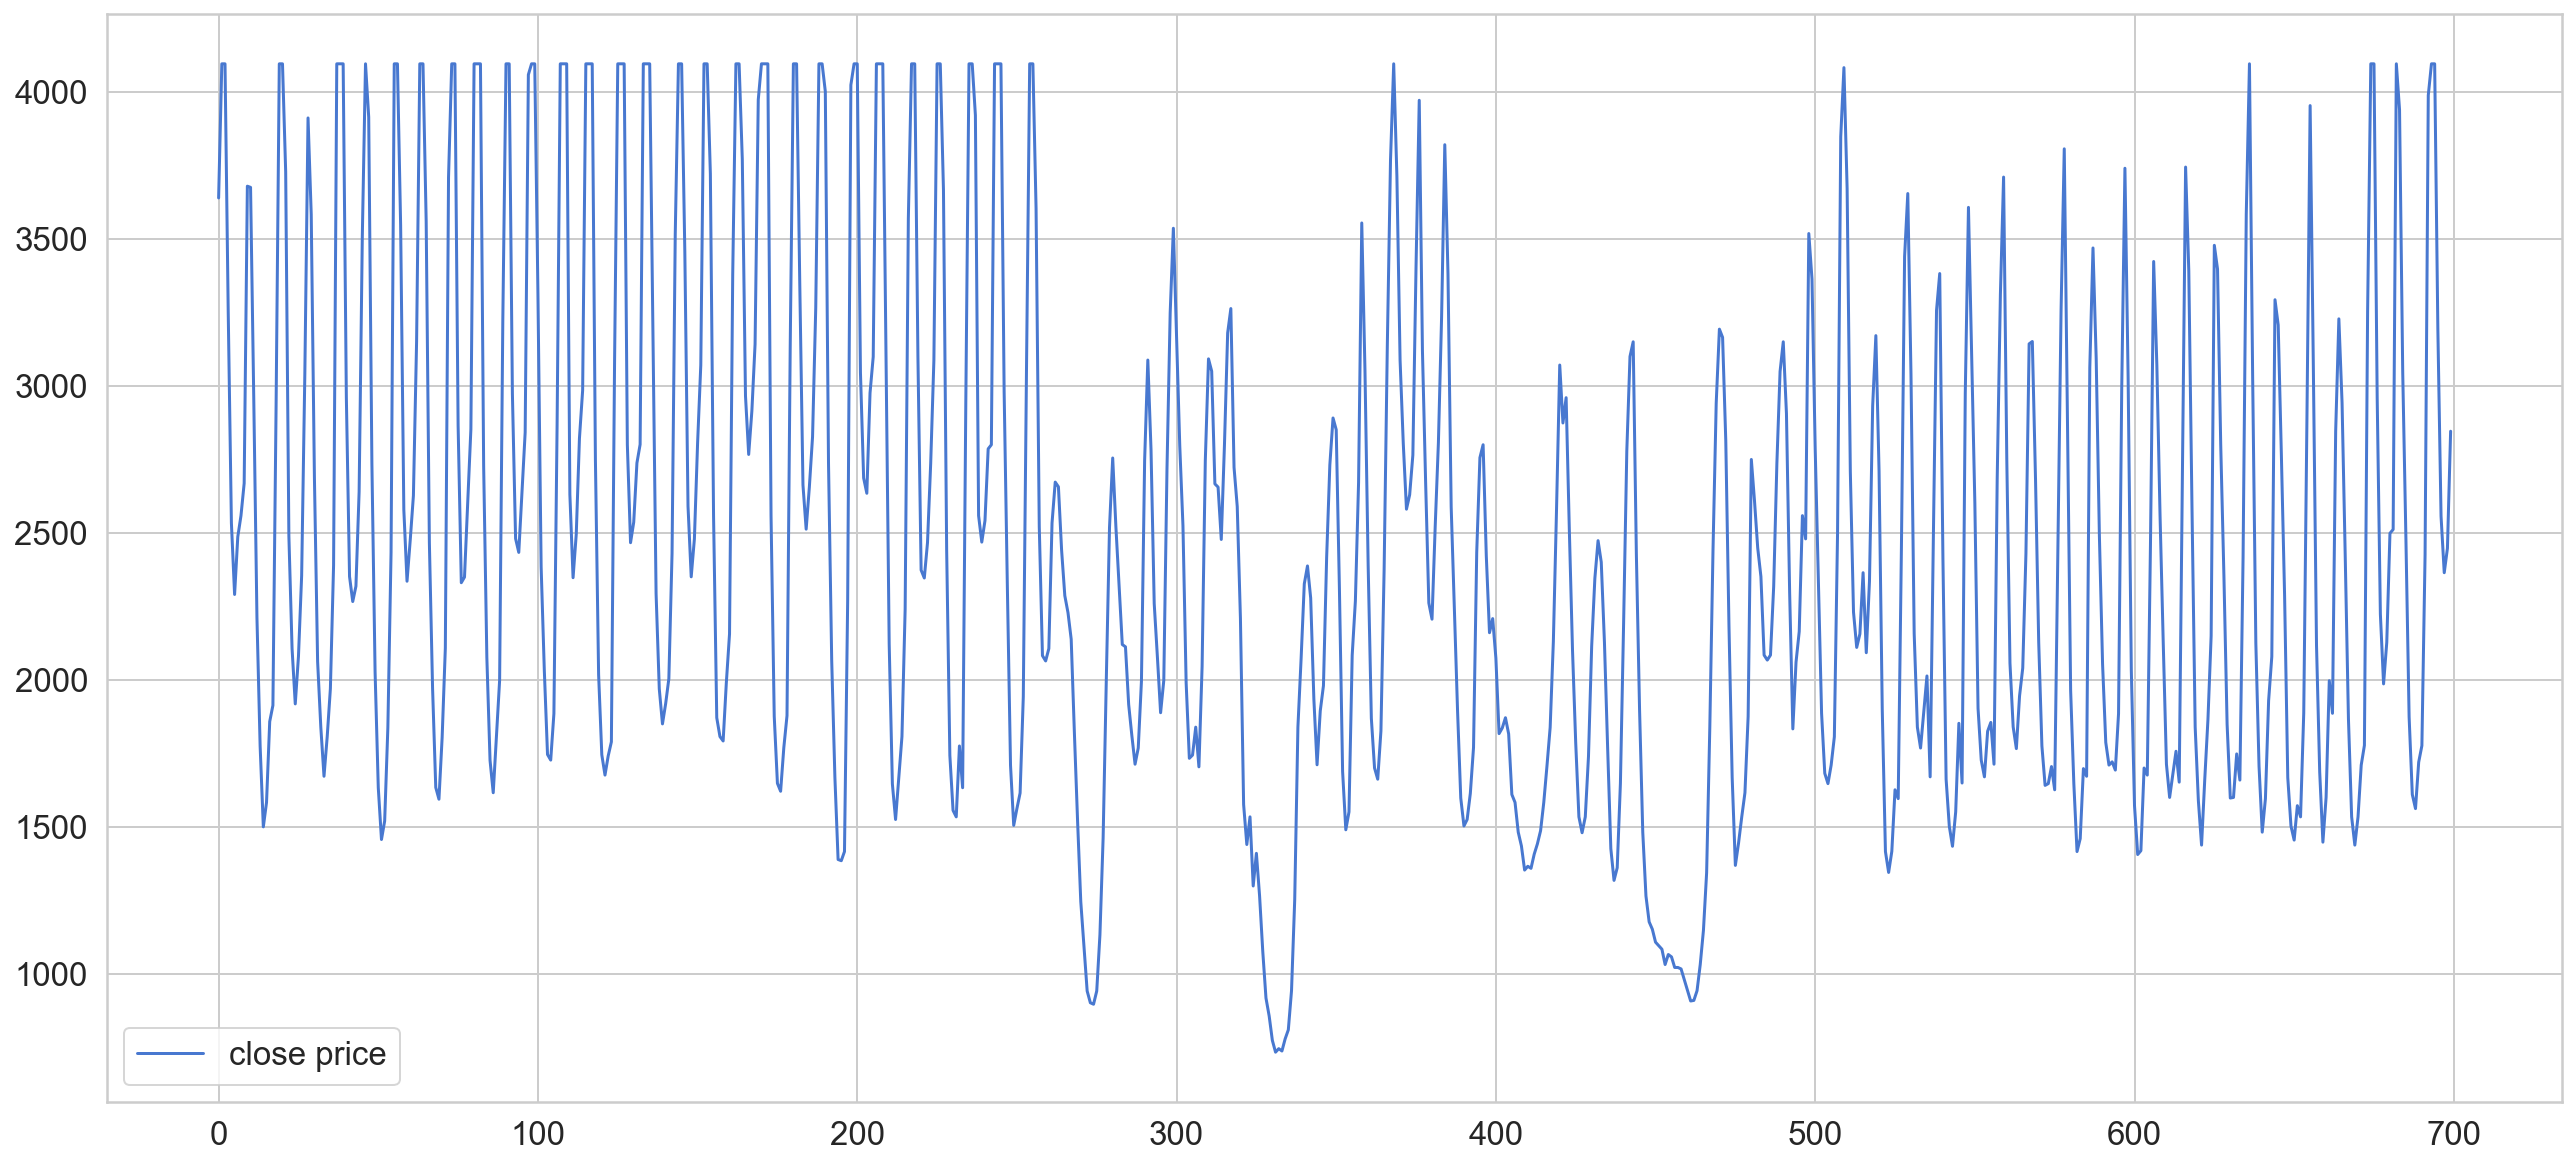

In [16]:
plt.plot(test, label='close price')
plt.legend();

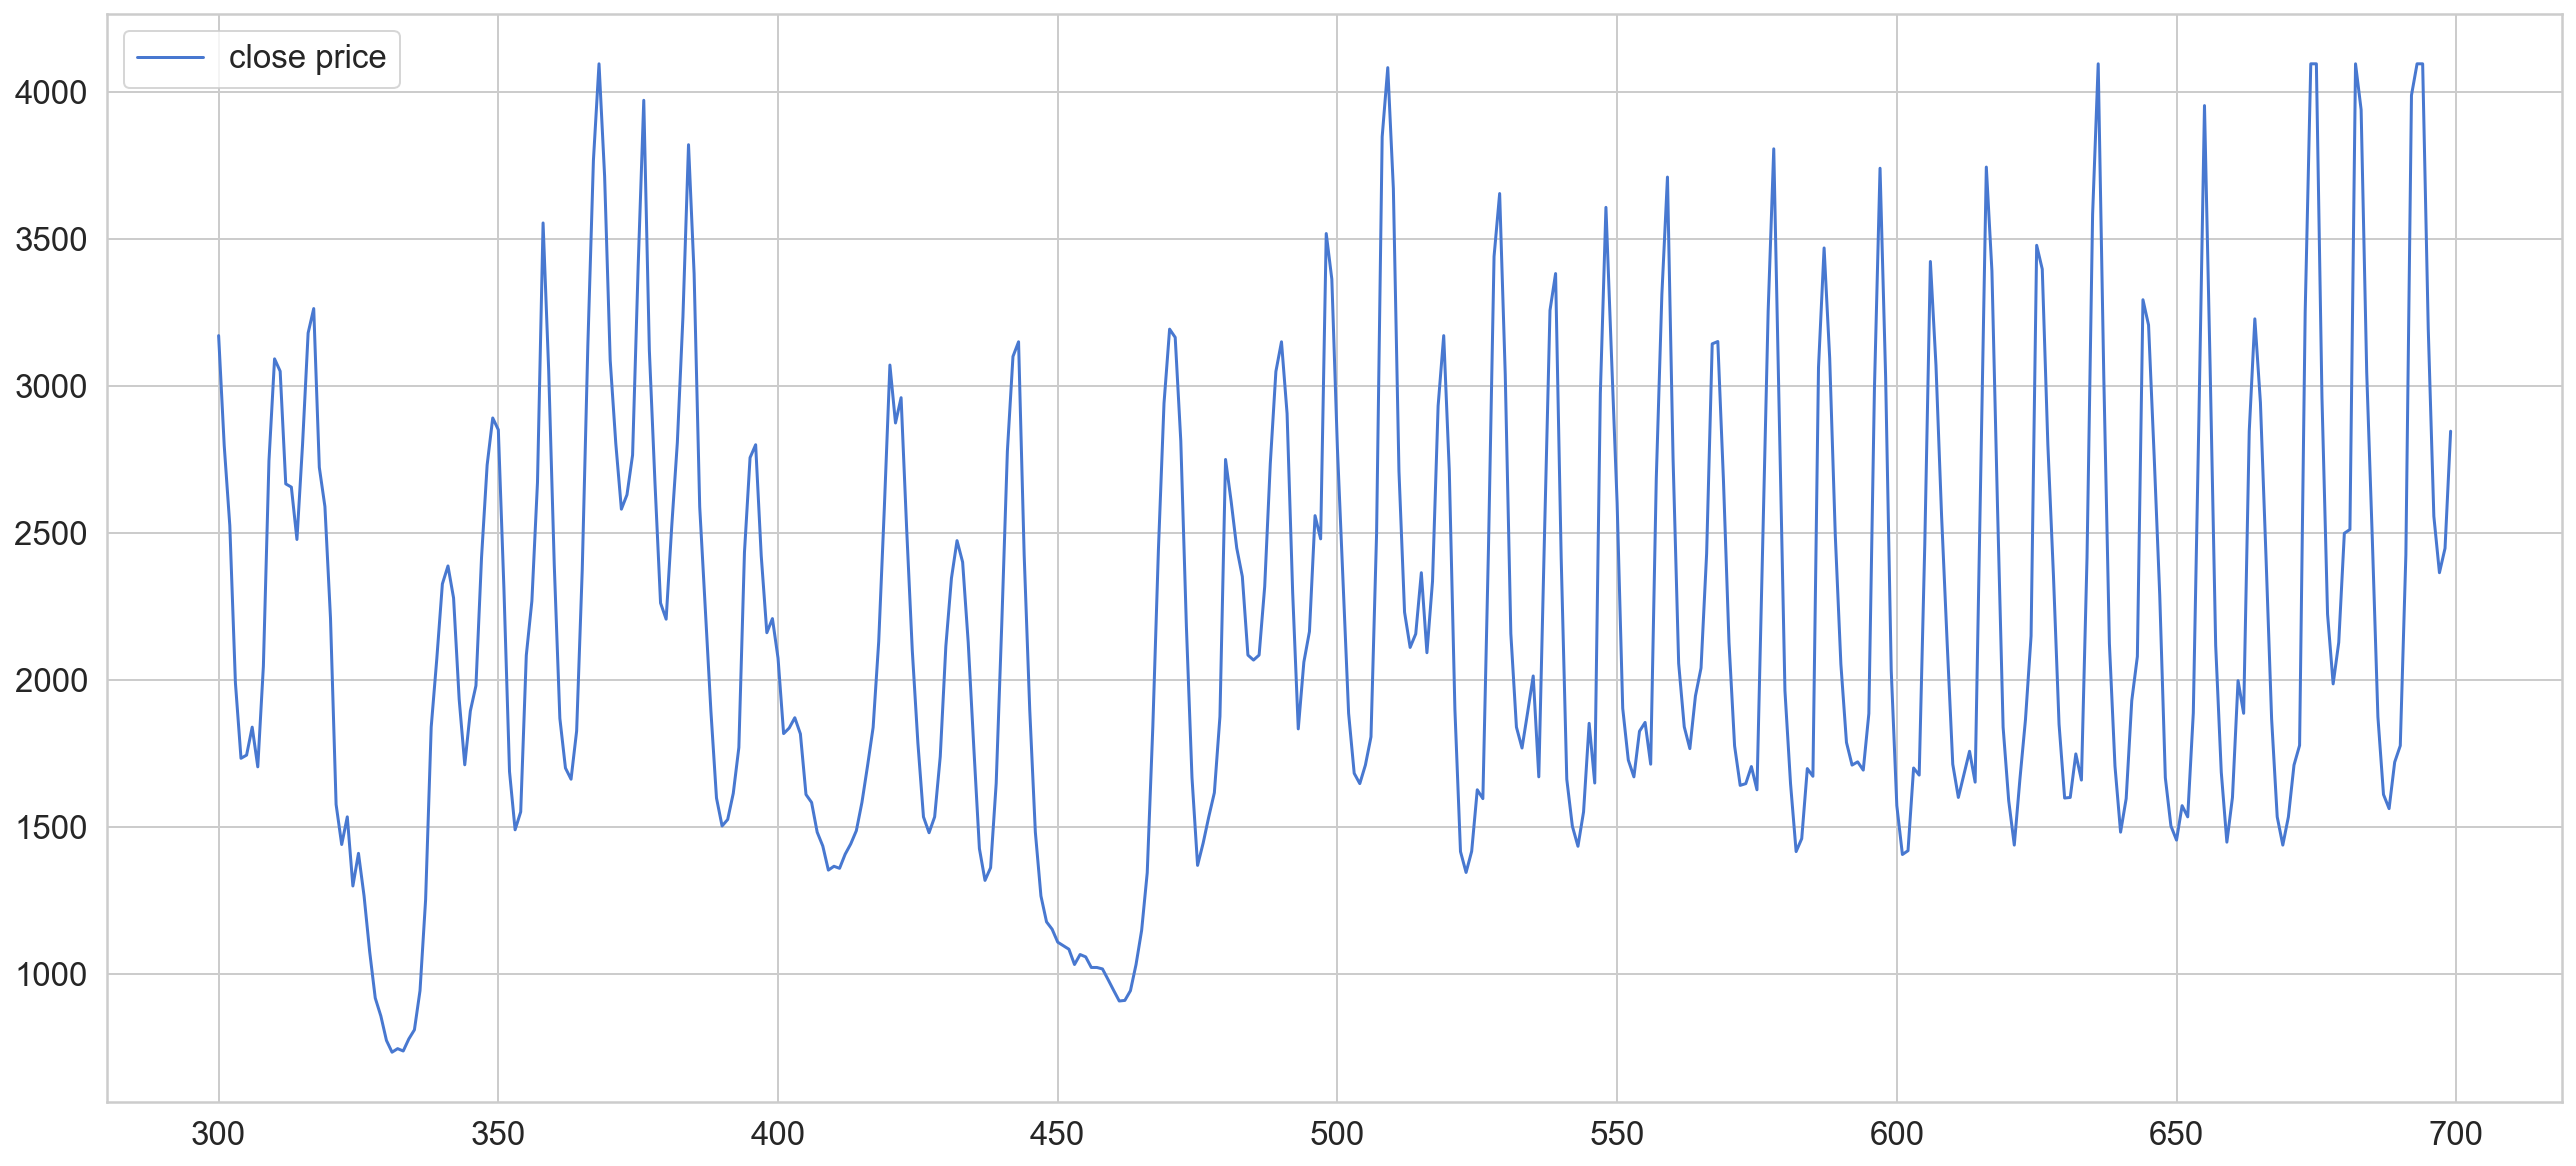

In [17]:
plt.plot(test[300: 900], label='close price')
plt.legend();

In [ ]:
train

## 訓練データとテストデータに分割

train 0~95%目

test 95%~100%

In [ ]:
# train_size = int(len(df) * 0.95)
# test_size = len(df) - train_size
# train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
# print(train.shape, test.shape)

## 標準化

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['data']])

train['data'] = scaler.transform(train[['data']])
test['data'] = scaler.transform(test[['data']])

## データセットの作成

30日間のデータから、31日目の値を推定する\
30日間のclose値のが入った配列と、31日目のcloseの値（これが目的の値）のセットを作る

`過去の30日間のデータセット,　31日目のデータ`このセットをいくつも作成

In [19]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [20]:
train[['data']].iloc[0:30].values

array([[ 0.28921471],
       [ 1.23060075],
       [ 0.89356131],
       [ 0.38089977],
       [-0.1330531 ],
       [-0.44813979],
       [-0.41456498],
       [-0.46621853],
       [-0.64958865],
       [-0.71028158],
       [-0.57339966],
       [ 0.0528997 ],
       [ 1.33390786],
       [ 1.78845915],
       [ 1.47982915],
       [-0.00521055],
       [-0.78517923],
       [-1.01374621],
       [-0.95821864],
       [-0.90398241],
       [-0.74514773],
       [-0.0865649 ],
       [ 1.02527787],
       [ 1.2254354 ],
       [ 0.61979746],
       [-0.06848616],
       [-0.56306895],
       [-0.82262806],
       [-0.84587216],
       [-0.64184062]])

In [21]:
train.data.iloc[31]
# train['close']

-0.7141555950778846

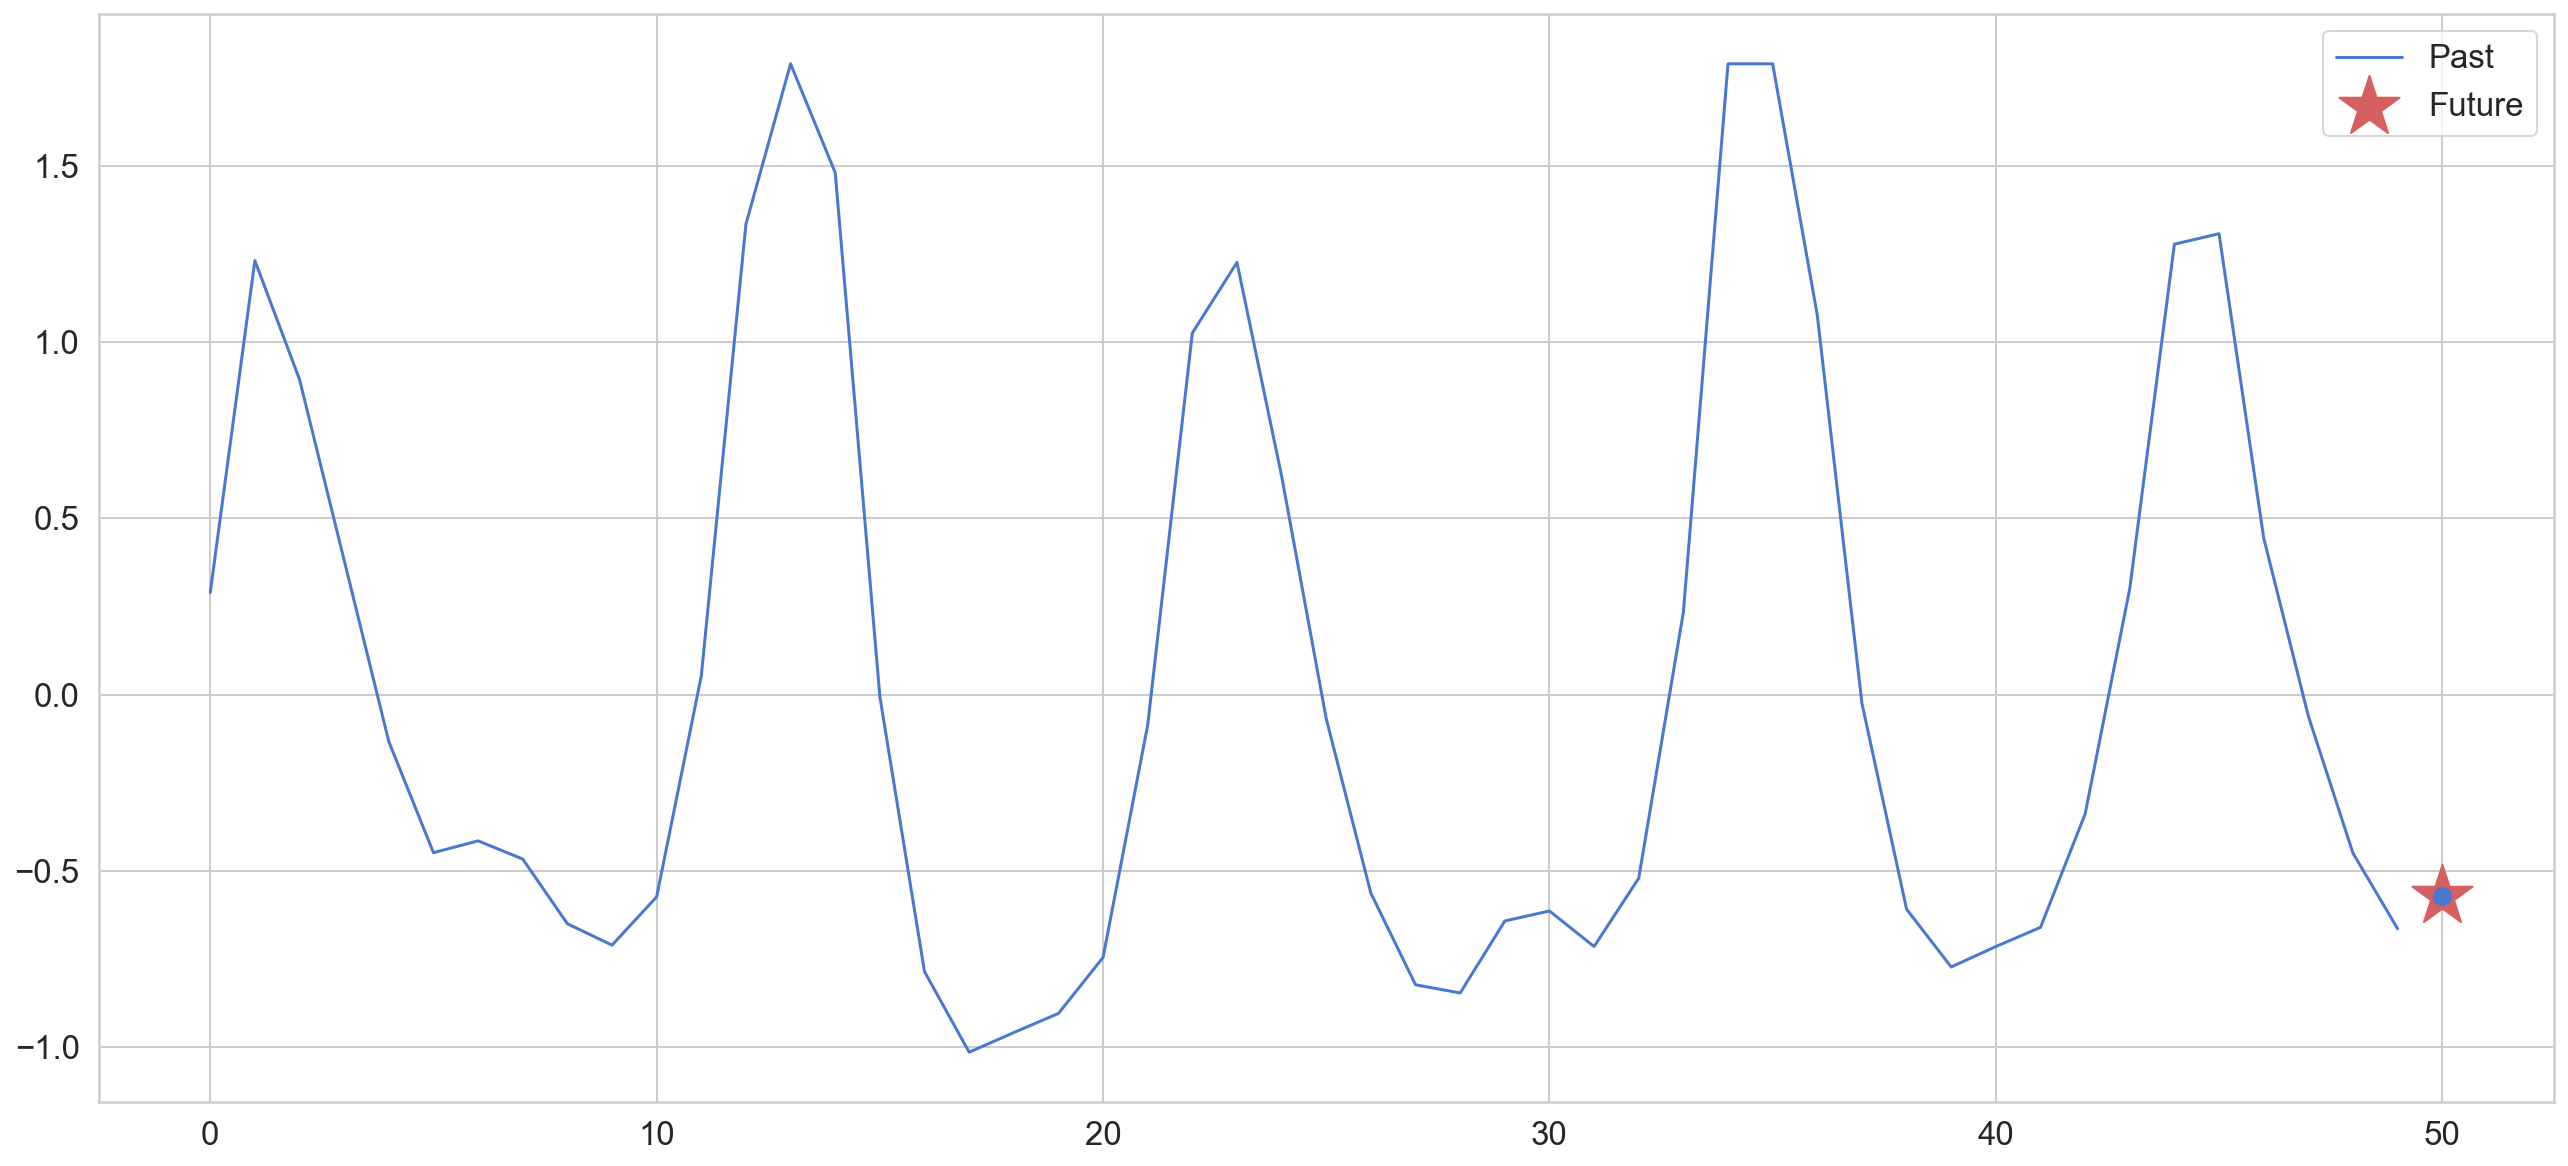

In [40]:
plt.plot(train[['data']].iloc[0:50].values, label='Past')
plt.scatter(50, train.data.iloc[50], c='r', marker='*', s=1000, label='Future')
plt.scatter(50, train.data.iloc[50], c='b', marker='.', s=300)
plt.legend();

In [ ]:
train

### データセット作成

In [43]:
TIME_STEPS = 50

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['data']], train.data, TIME_STEPS)
X_test, y_test = create_dataset(test[['data']], test.data, TIME_STEPS)

print(X_train.shape)
print(y_train.shape)
print(train.shape)
print(X_train.shape[1])
print(X_train.shape[2])
print(len(train[['data']]-TIME_STEPS))
X_train


(950, 50, 1)
(950,)
(1000, 1)
50
1
1000


array([[[ 0.28921471],
        [ 1.23060075],
        [ 0.89356131],
        ...,
        [-0.06073812],
        [-0.44943113],
        [-0.66379338]],

       [[ 1.23060075],
        [ 0.89356131],
        [ 0.38089977],
        ...,
        [-0.44943113],
        [-0.66379338],
        [-0.56952564]],

       [[ 0.89356131],
        [ 0.38089977],
        [-0.1330531 ],
        ...,
        [-0.66379338],
        [-0.56952564],
        [-0.58502171]],

       ...,

       [[-1.40502189],
        [-1.11317931],
        [ 0.20527768],
        ...,
        [ 1.78845915],
        [ 1.78845915],
        [ 1.00849046]],

       [[-1.11317931],
        [ 0.20527768],
        [ 1.78845915],
        ...,
        [ 1.78845915],
        [ 1.00849046],
        [-0.19503737]],

       [[ 0.20527768],
        [ 1.78845915],
        [ 1.78845915],
        ...,
        [ 1.00849046],
        [-0.19503737],
        [-0.50237602]]])

### モデルの作成

In [44]:
model = keras.Sequential()
#LSTMレイヤの作成、ユニットとインプットのシェイプを確定
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
#正規化
model.add(keras.layers.Dropout(rate=0.2))
#コピー？
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [67]:
print(X_train.shape[1], X_train.shape[2])

50 1


### モデルの学習

In [45]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
27/27 [==============================] - 1s 55ms/step - loss: 0.6669 - val_loss: 0.5358
Epoch 2/10
27/27 [==============================] - 1s 30ms/step - loss: 0.4768 - val_loss: 0.3748
Epoch 3/10
27/27 [==============================] - 1s 29ms/step - loss: 0.3872 - val_loss: 0.2974
Epoch 4/10
27/27 [==============================] - 1s 30ms/step - loss: 0.3375 - val_loss: 0.2539
Epoch 5/10
27/27 [==============================] - 1s 33ms/step - loss: 0.3091 - val_loss: 0.2430
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 0.2932 - val_loss: 0.2293
Epoch 7/10
27/27 [==============================] - 1s 30ms/step - loss: 0.2808 - val_loss: 0.2224
Epoch 8/10
27/27 [==============================] - 1s 30ms/step - loss: 0.2772 - val_loss: 0.2171
Epoch 9/10
27/27 [==============================] - 1s 30ms/step - loss: 0.2617 - val_loss: 0.2028
Epoch 10/10
27/27 [==============================] - 1s 30ms/step - loss: 0.2607 - val_loss: 0.2054


TypeError: 'dict' object is not callable

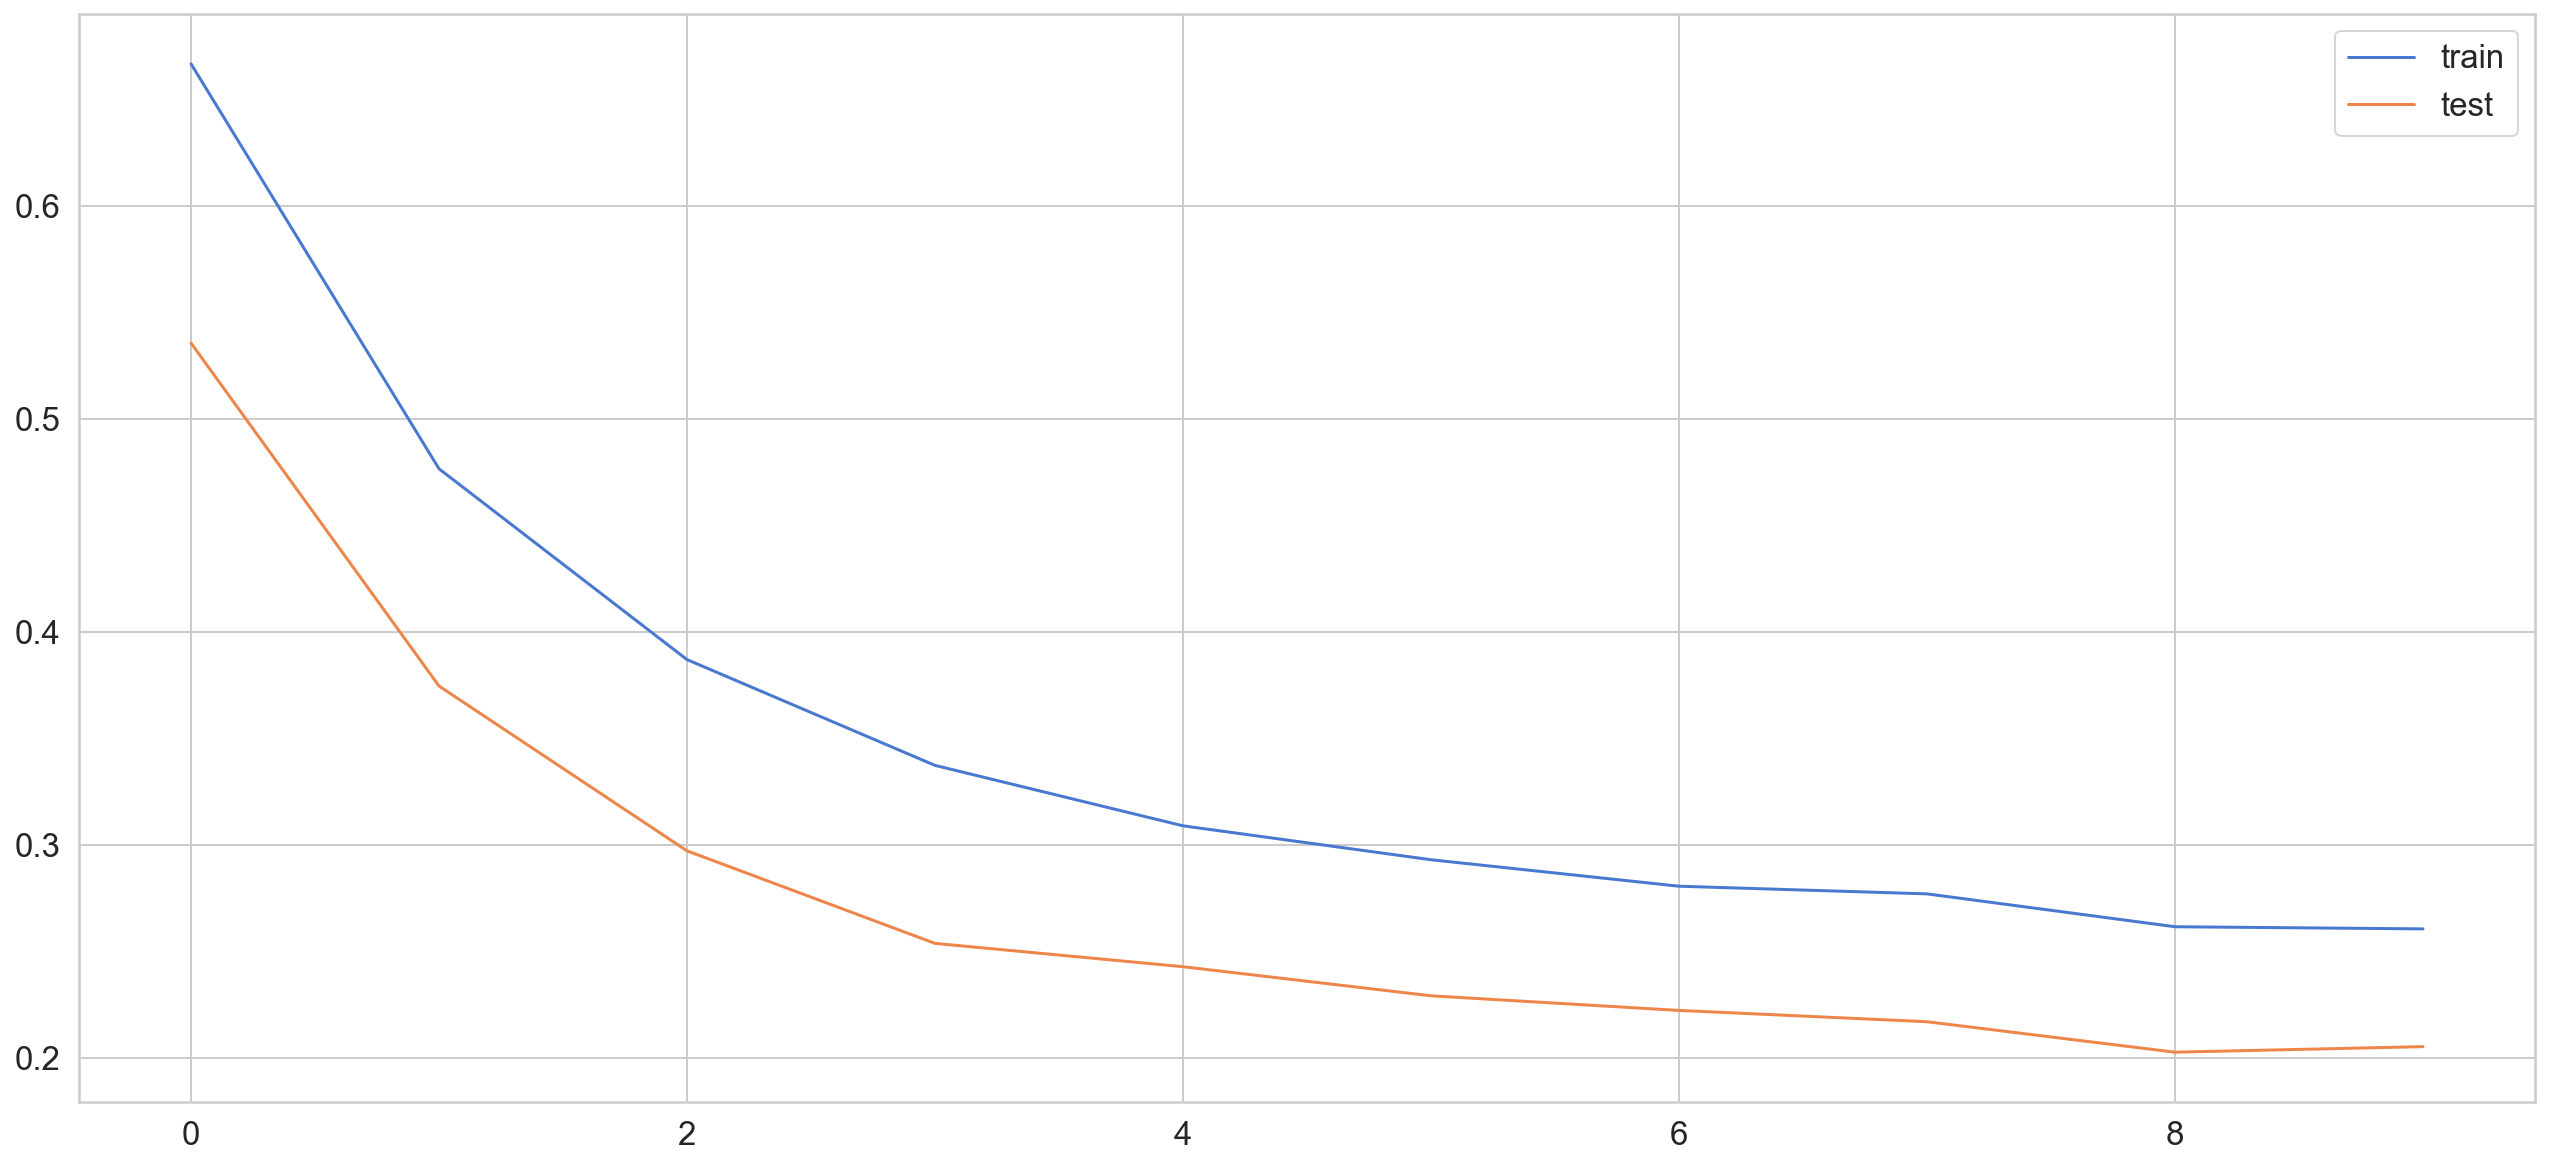

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### 推定誤差を比べる

In [63]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

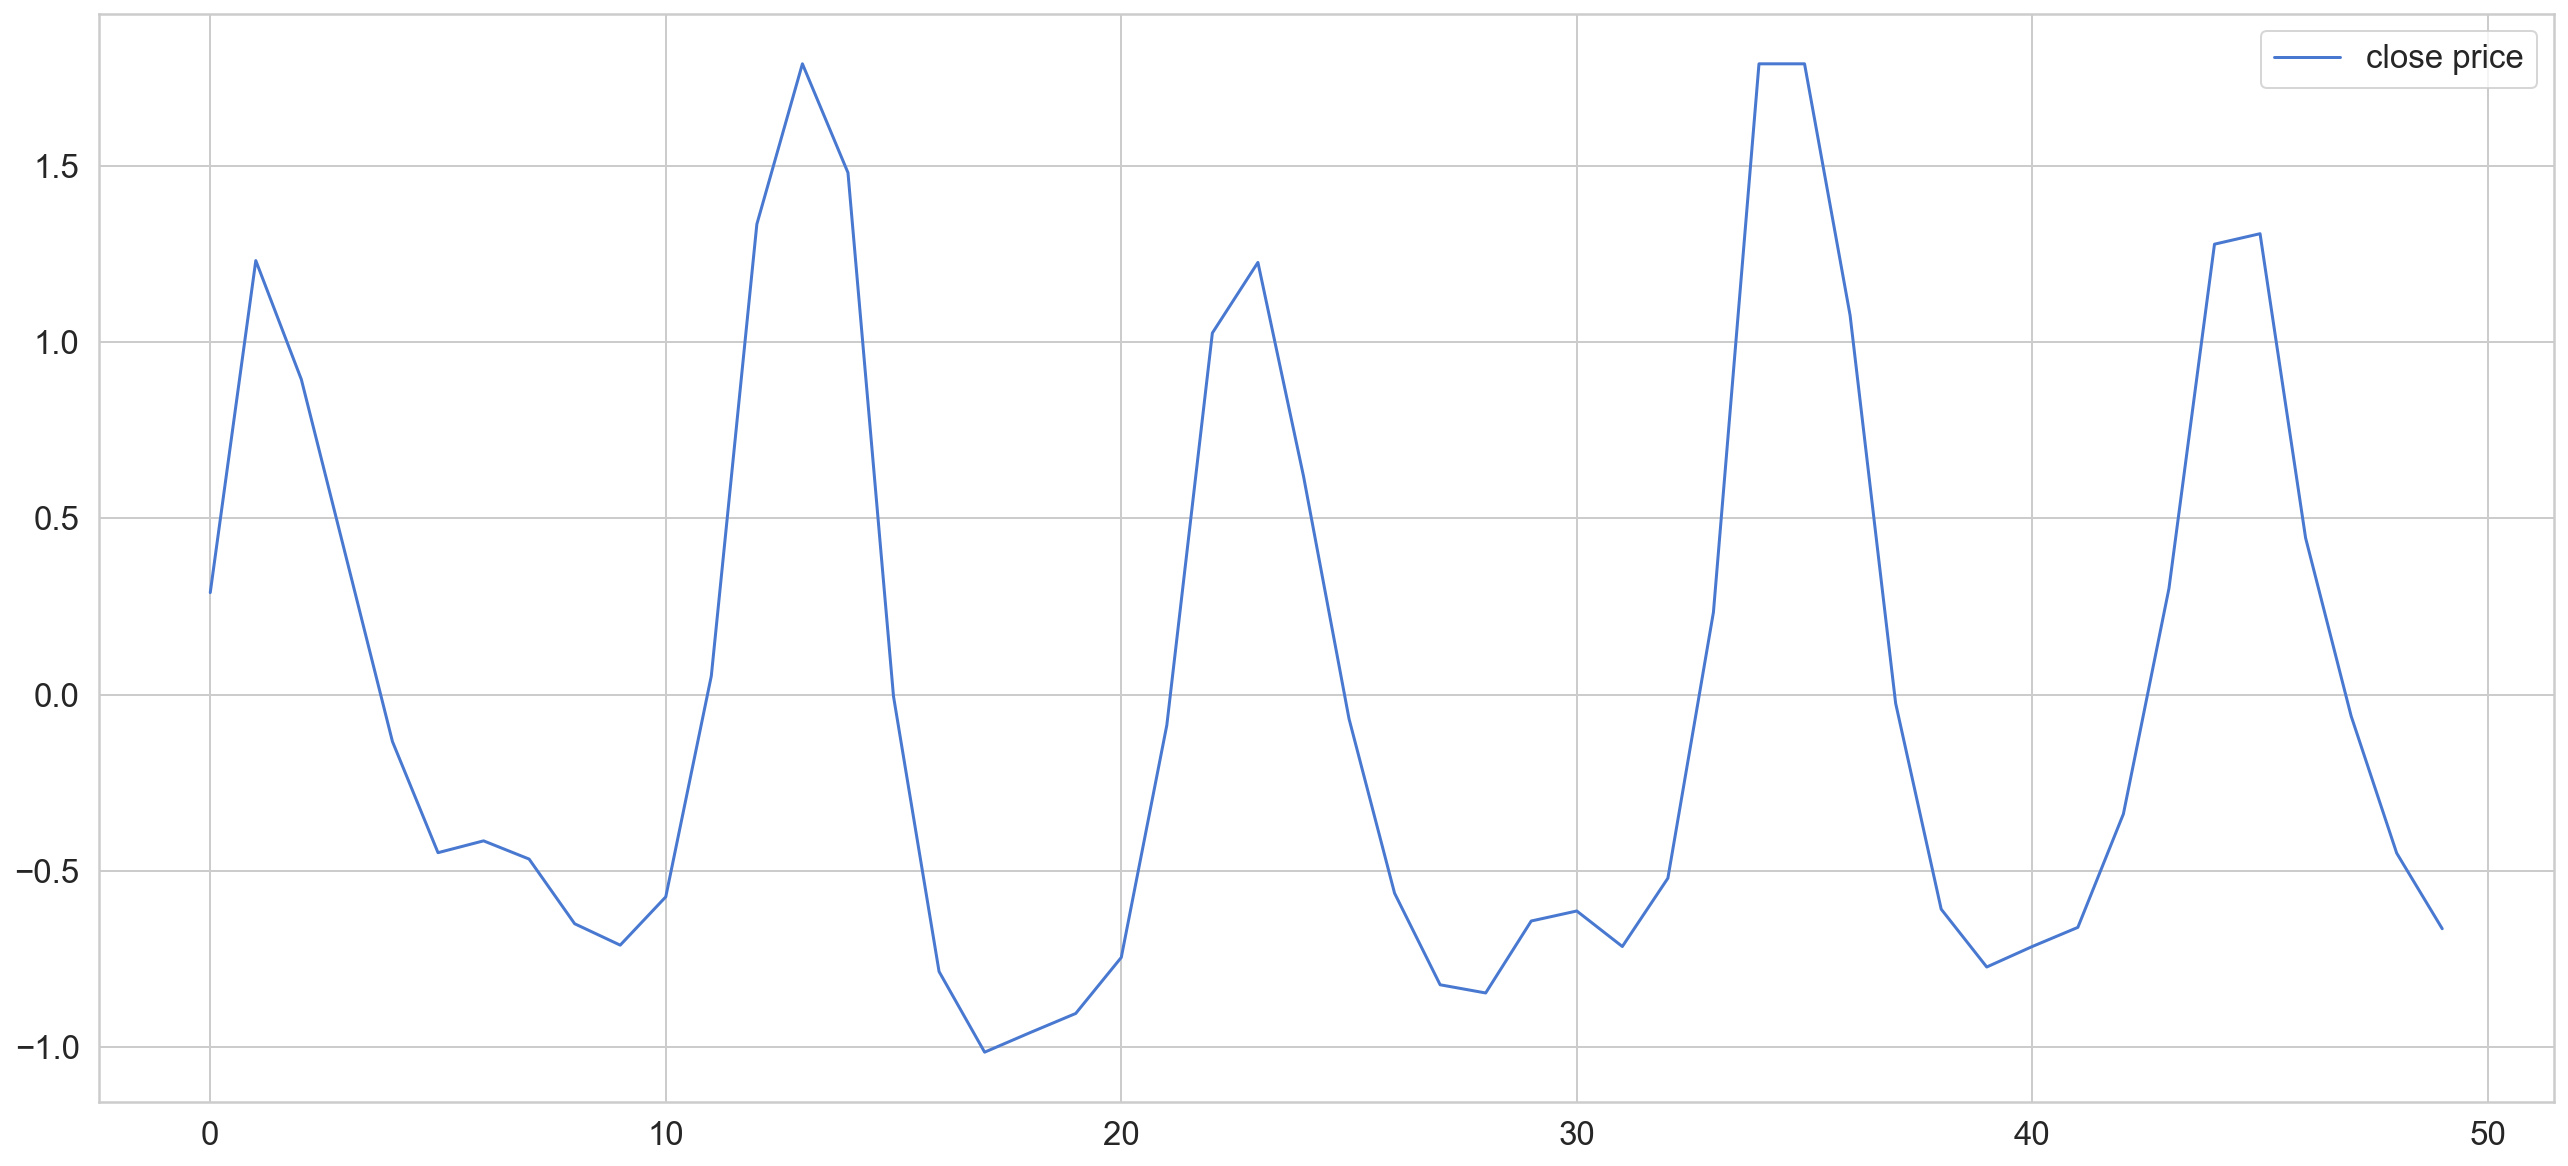

In [79]:
X_train_pred.shape

# plt.plot(X_train_pred[0], label='pred')
plt.plot(X_train[0], label='close price')
plt.legend();

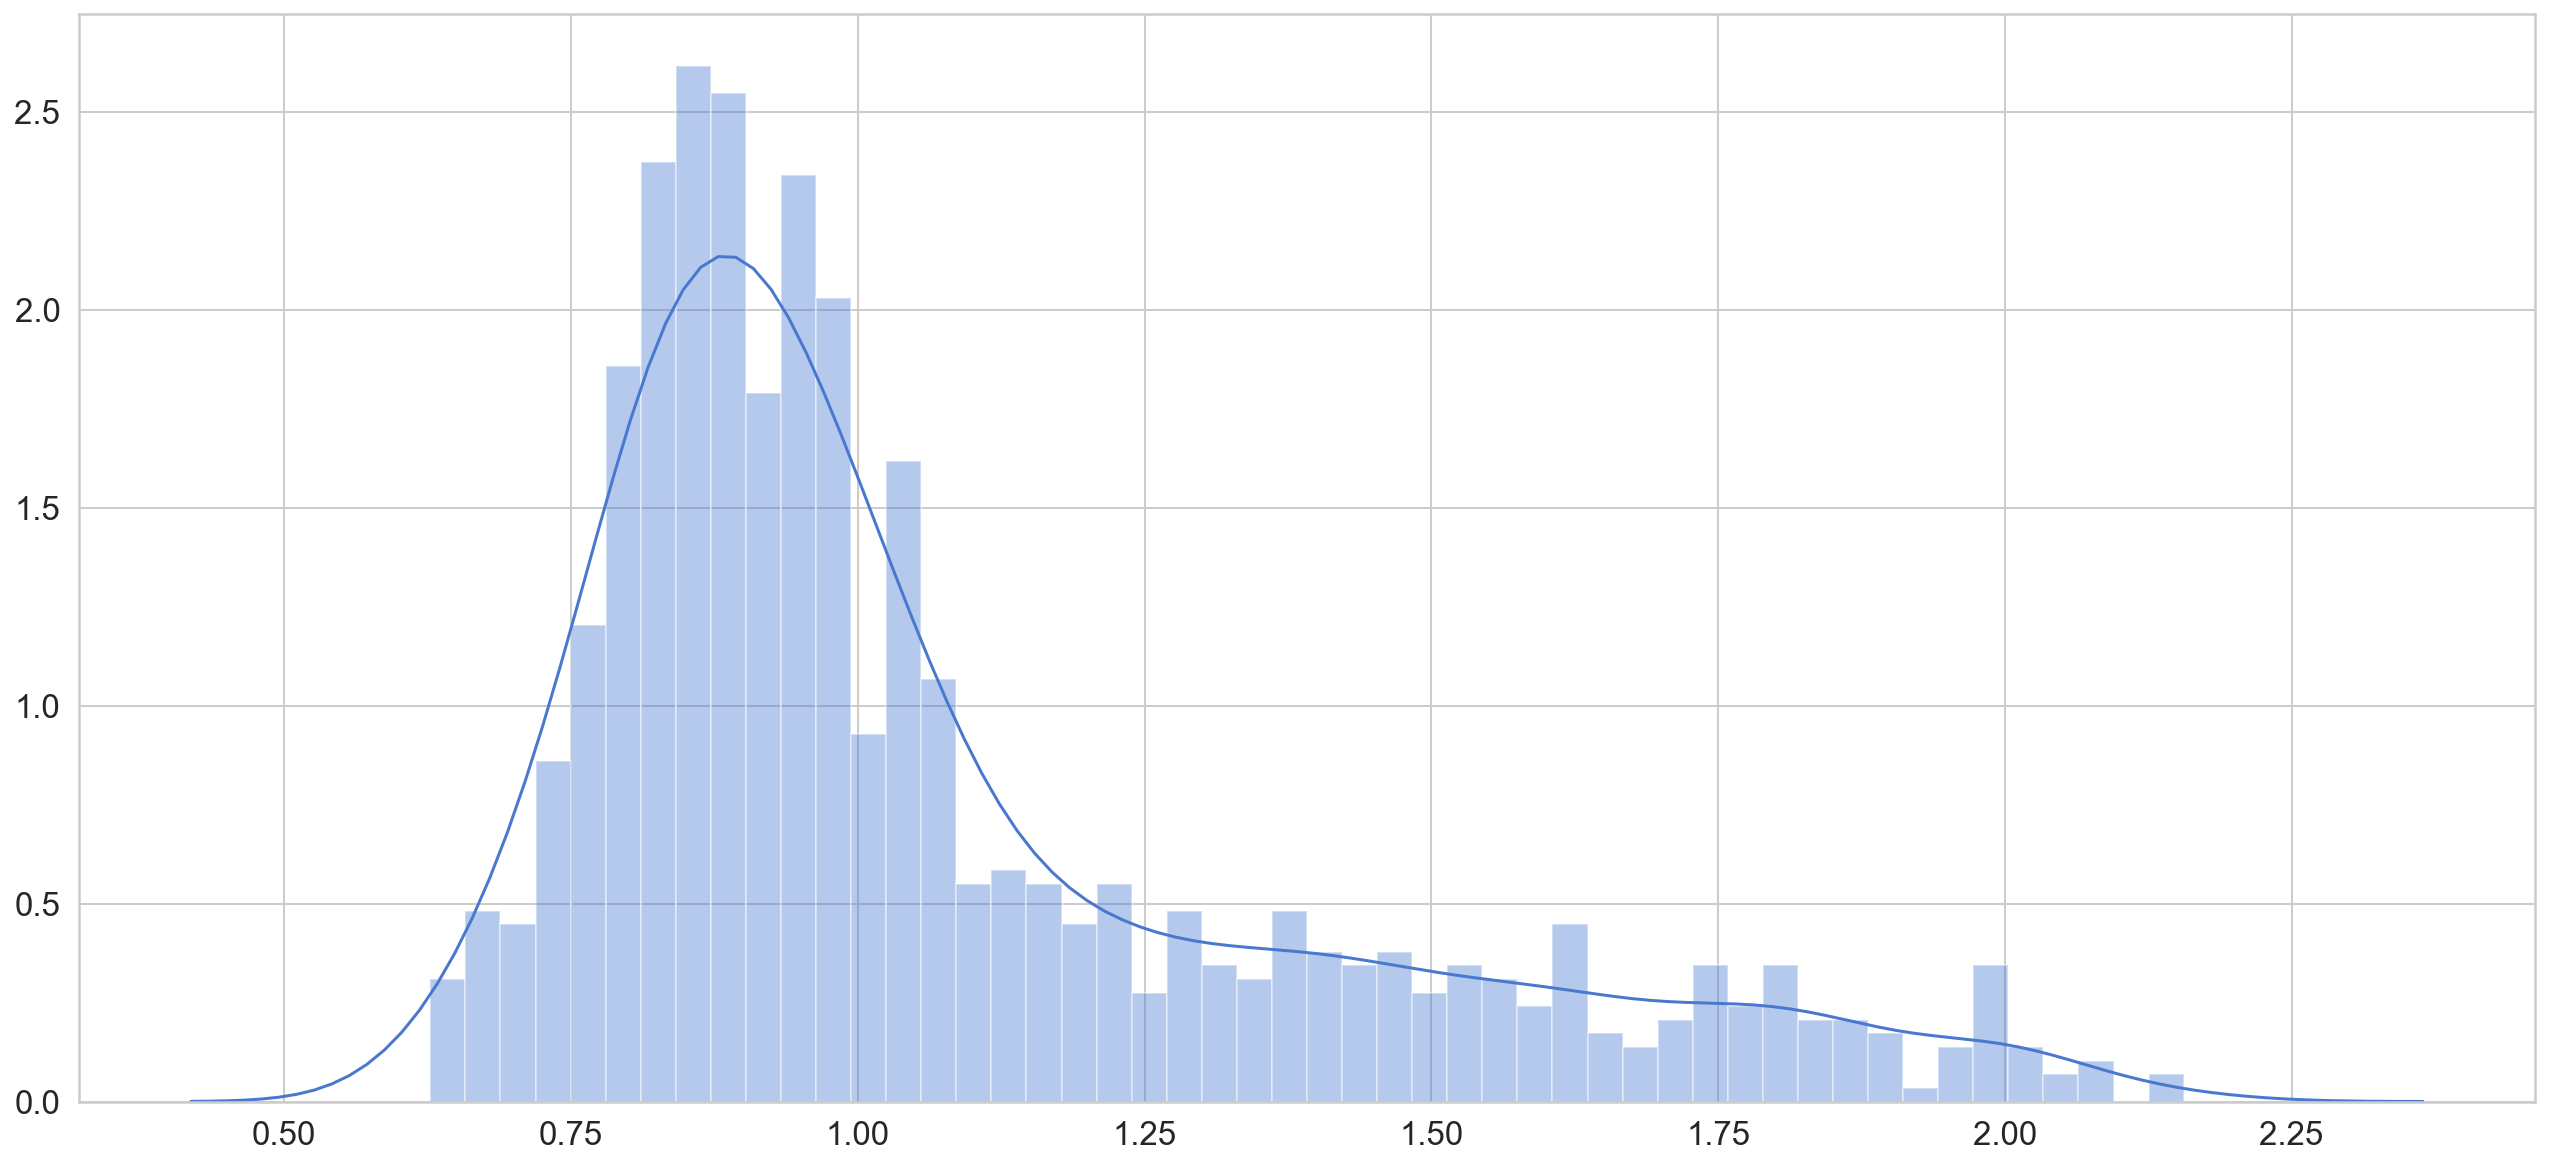

In [48]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [49]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [57]:
THRESHOLD = 2.2

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['data'] = test[TIME_STEPS:].data

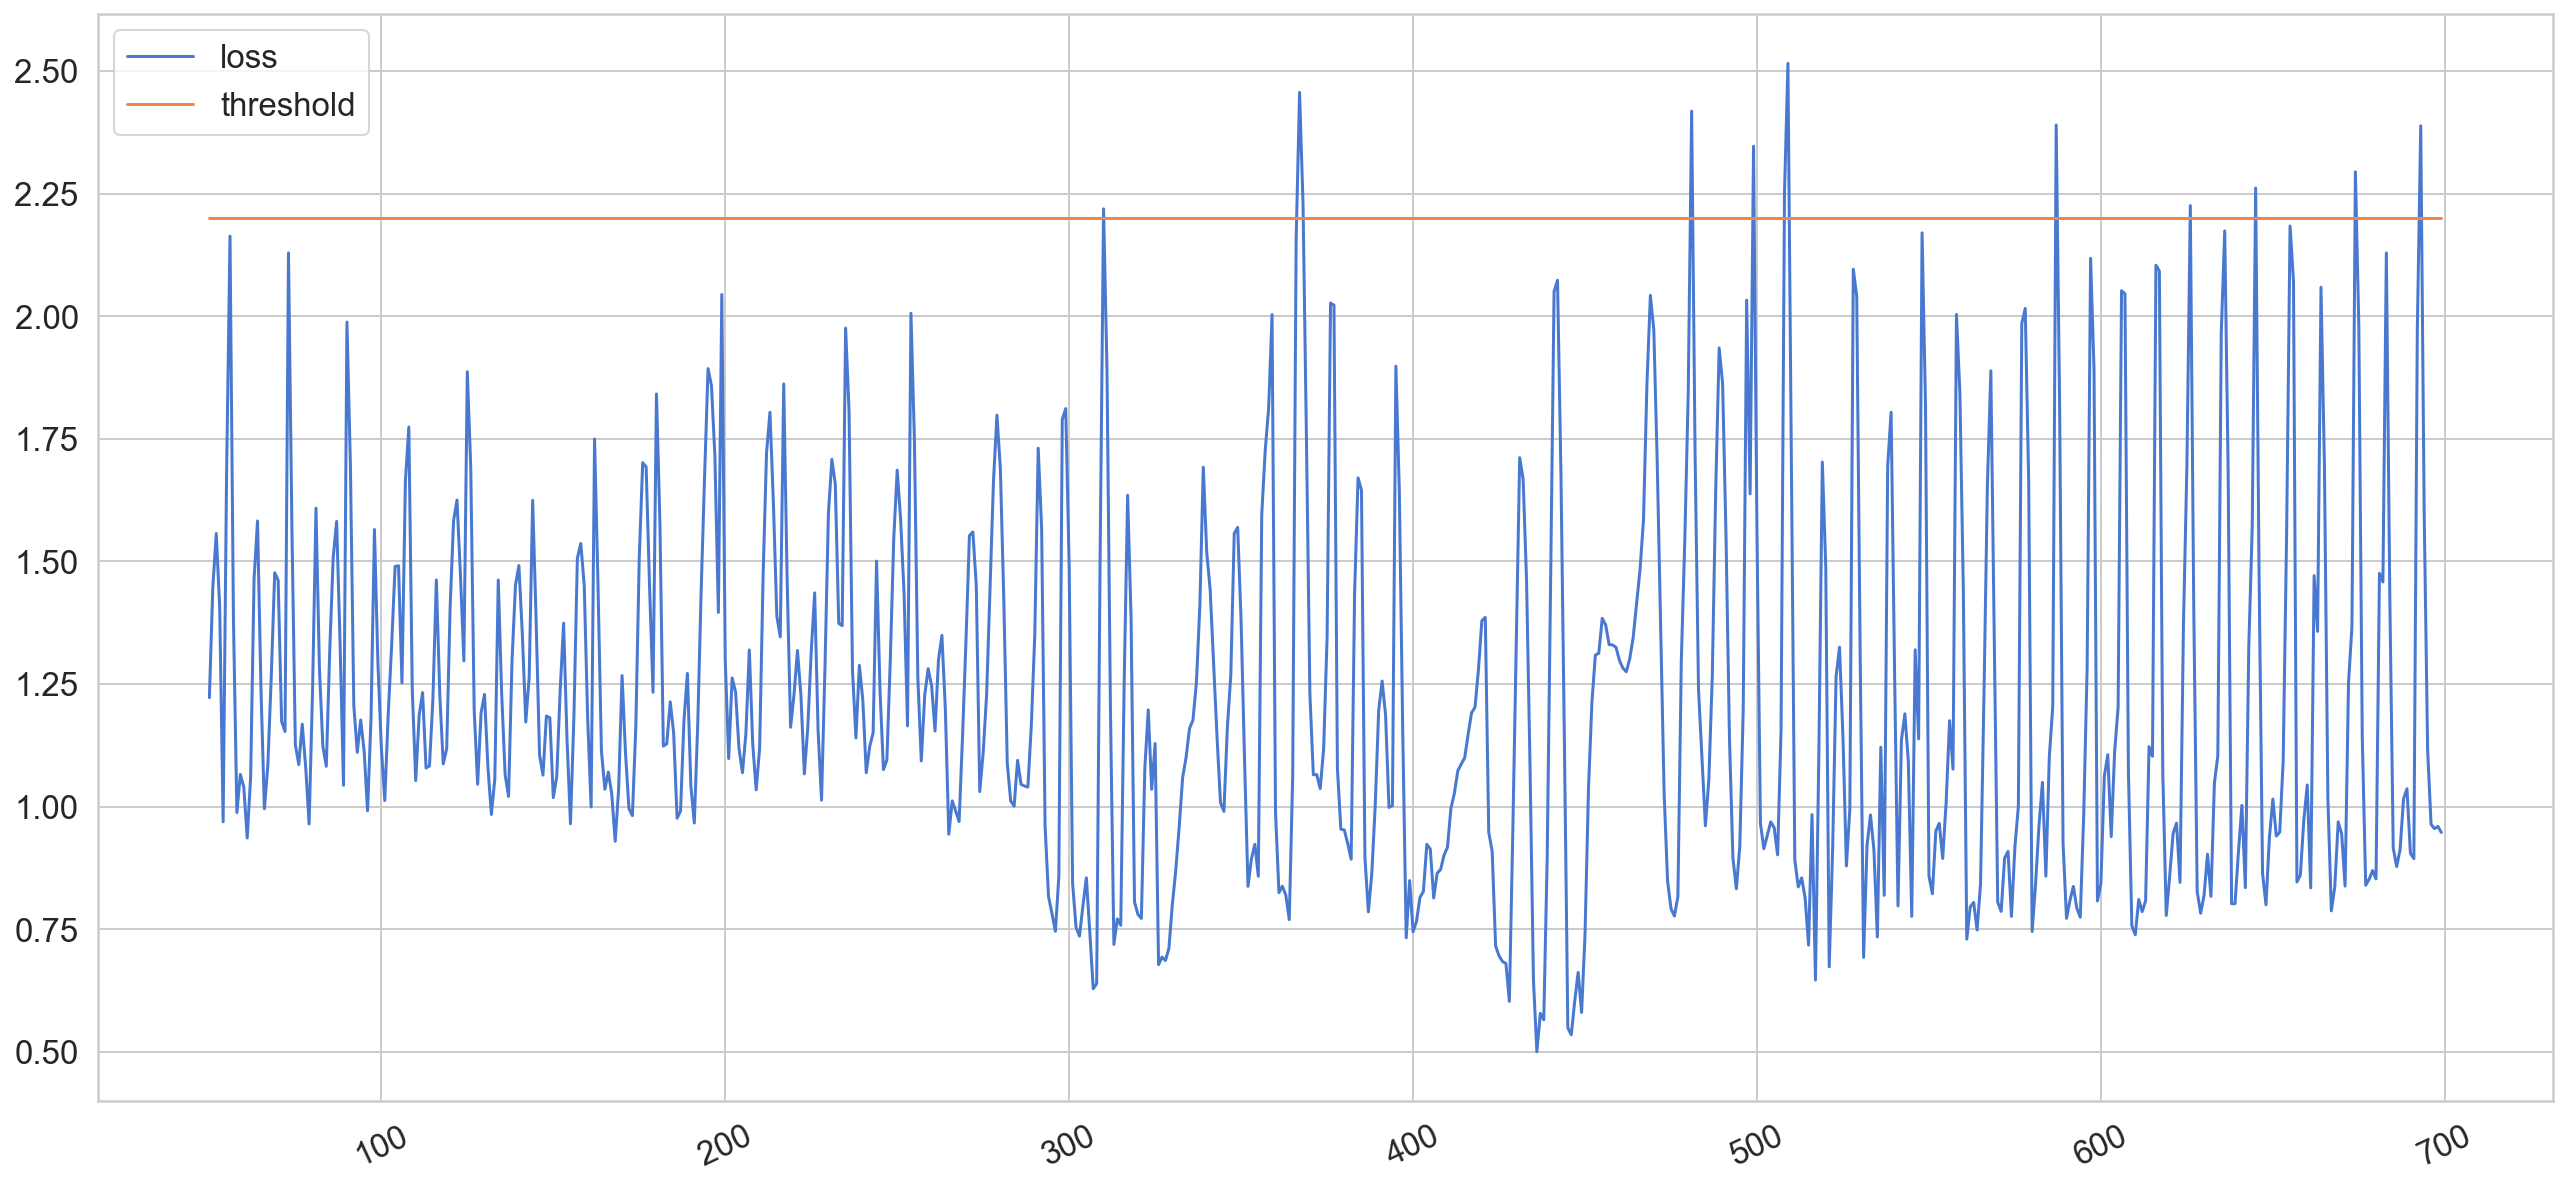

In [51]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [52]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,data
310,2.218880,2.2,True,0.493246
367,2.456127,2.2,True,1.364900
368,2.229973,2.2,True,1.788459
481,2.418008,2.2,True,-0.131762
499,2.346480,2.2,True,0.843199


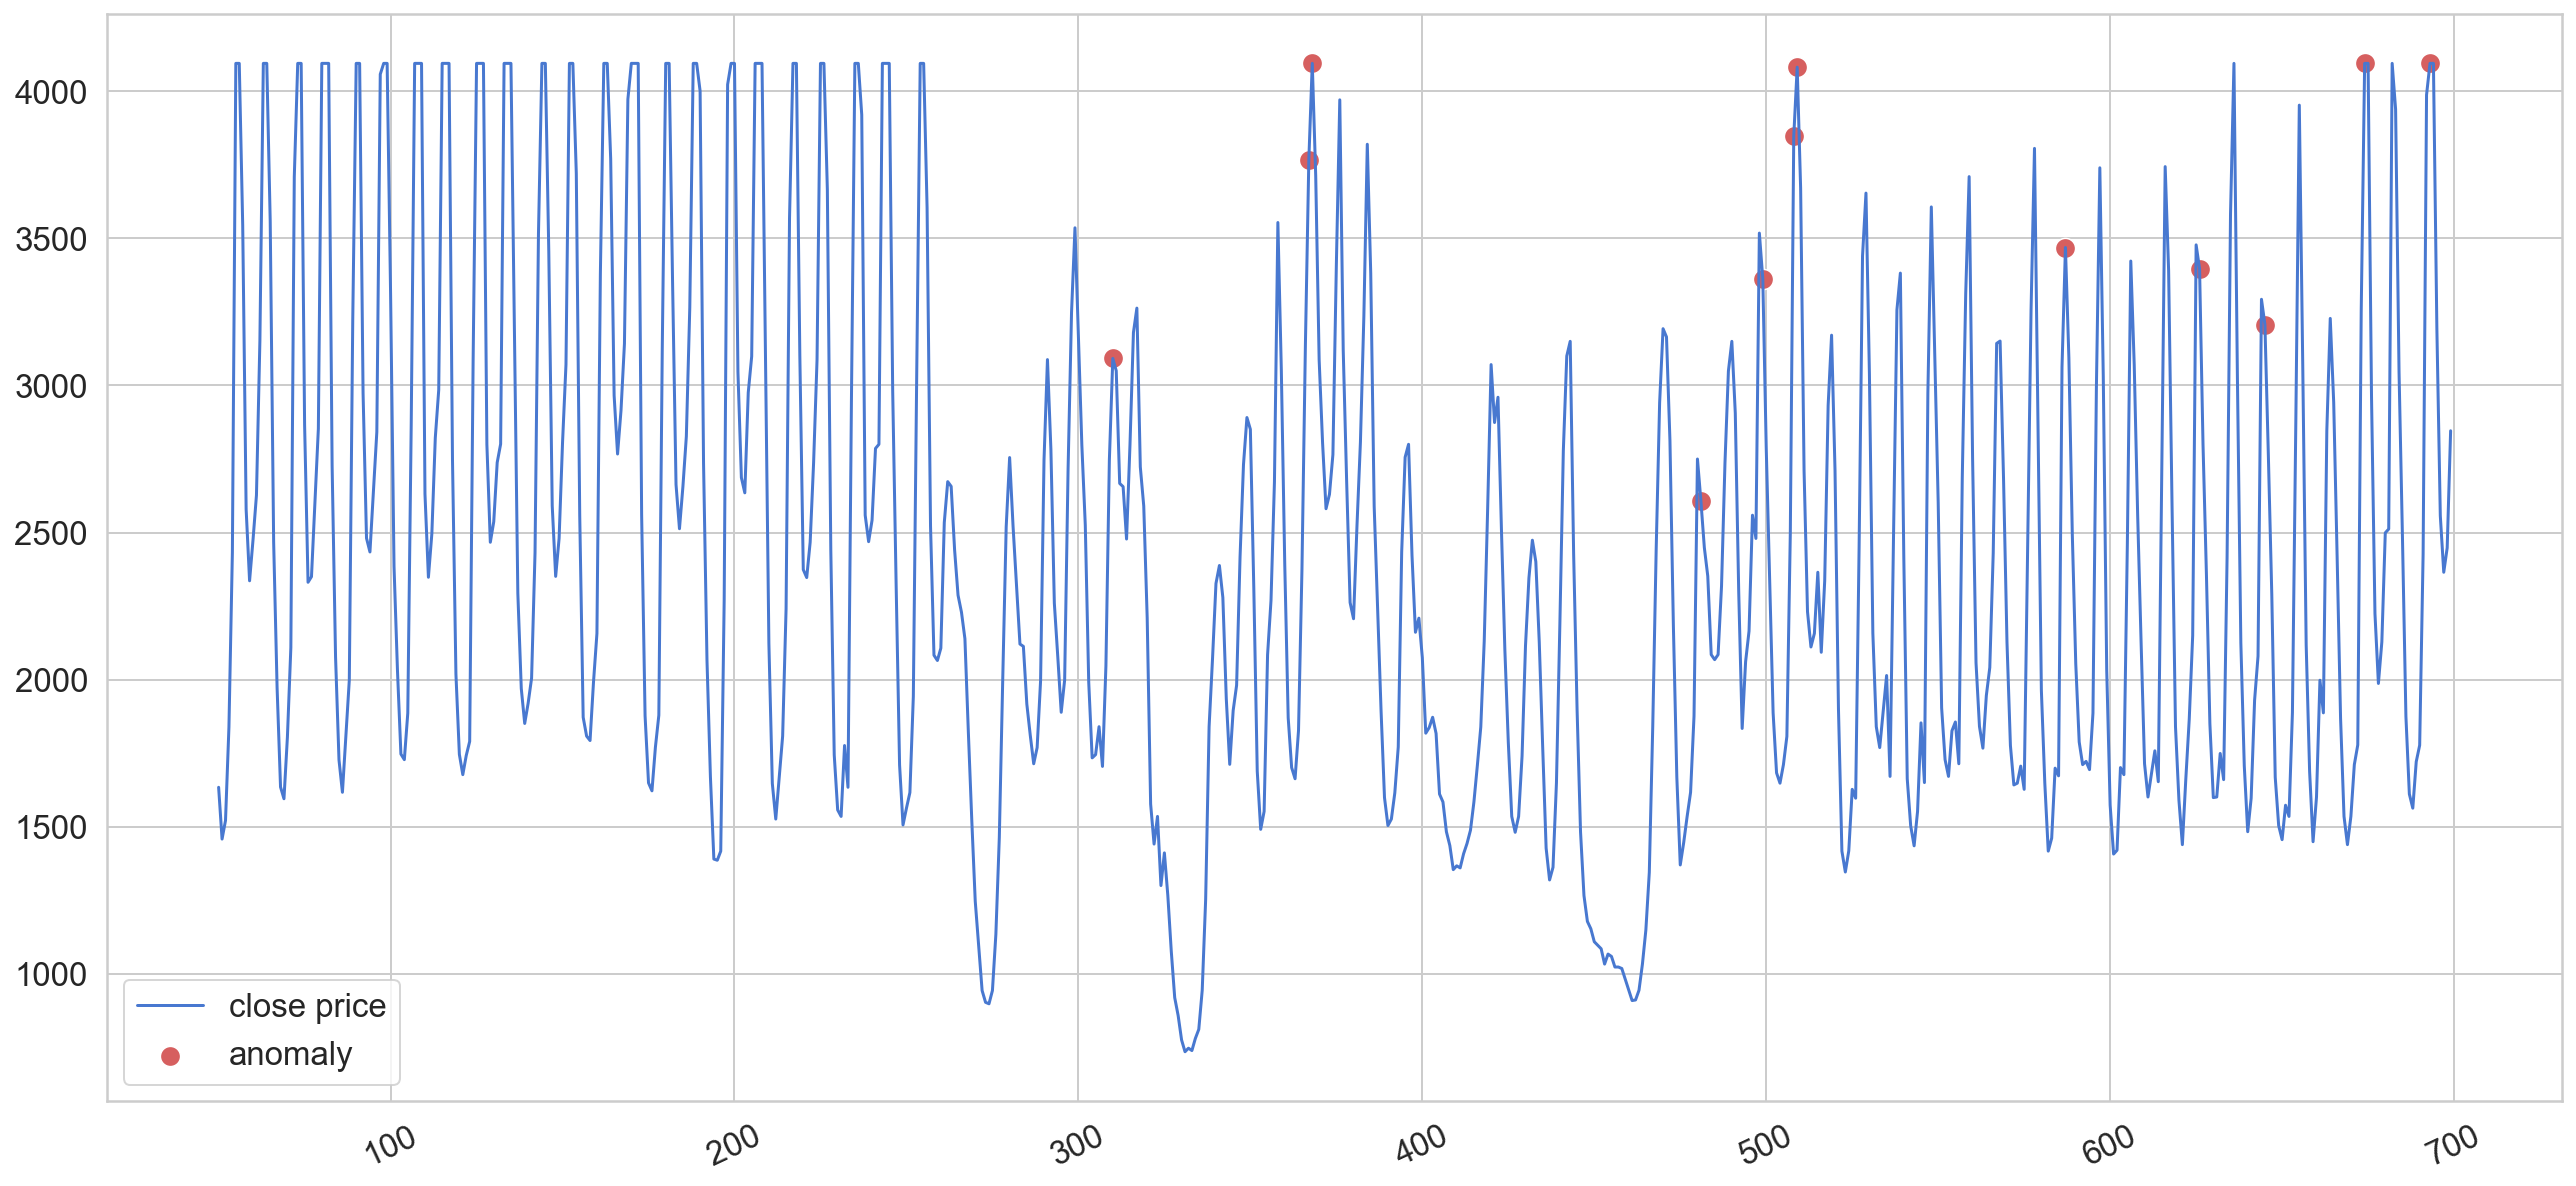

In [53]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].data), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.data),
  color=sns.color_palette()[3],
  s=102,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

https://www.youtube.com/watch?v=xaIA83x5Icg

https://www.curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/

https://www.curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/

## sinの関数を予測

https://medium.com/@krzysztofbalka/training-keras-lstm-to-generate-sine-function-2e3c0ca42c3b

## ノイズデータ

https://www.machinecurve.com/index.php/2019/12/19/creating-a-signal-noise-removal-autoencoder-with-keras/